In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from ipynb.fs.full.data_preprocessing_function import preprocessing_data

In [2]:
#reading data
list_Xtrain=[]
list_Xtest=[]
list_ytrain=[]
list_ytest=[]

overview = pd.read_excel('../osfstorage-archive/pmdata/participant-overview.xlsx')
overview = overview.set_axis(overview.iloc[0,:],axis='columns').set_index('Participant ID',drop=True)

for x in range(1, 17):
    person_number = x
    
    person_number = str('%02d' % person_number)

    calories = []
    distance = []
    l_act = []
    m_act = []
    r_heart = []
    sedentary = []
    sleep_score = []
    sleep = []
    hr_zone = []
    v_act = []
    wellness = []
    
    display('P'+person_number)
    
    try:

        calories = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/calories.json')
        distance = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/distance.json')
        l_act = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/lightly_active_minutes.json')
        m_act = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/moderately_active_minutes.json')
        r_heart = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/resting_heart_rate.json')
        sedentary = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/sedentary_minutes.json')
        sleep_score = pd.read_csv('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/sleep_score.csv')
        sleep = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/sleep.json')
        steps = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/steps.json')
        hr_zone = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/time_in_heart_rate_zones.json')
        v_act = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/very_active_minutes.json')
        wellness = pd.read_csv('../osfstorage-archive/pmdata/p'+person_number+'/pmsys/wellness.csv')  


        if x in [8,14]:
            preprocessing_result = preprocessing_data(person_number, calories, distance, l_act, m_act, r_heart, sedentary, sleep_score, sleep, steps, hr_zone, v_act, wellness)
            display('P'+person_number+' extra columns dropped')
        else:
            preprocessing_result = preprocessing_data(person_number, calories, distance, l_act, m_act, r_heart, sedentary, sleep_score, sleep, steps, hr_zone, v_act, wellness)

        #handling missing values on target
        preprocessing_result['readiness'] = preprocessing_result['readiness'].shift(periods=-1) #shift next date's readiness to current date
      
        preprocessing_result = preprocessing_result[preprocessing_result['readiness'].notna()] #drop missing values on readiness

        #zero values with core attributes to nan
        preprocessing_result['calories'] = preprocessing_result['calories'].replace(0,np.nan)
        preprocessing_result['distance'] = preprocessing_result['distance'].replace(0,np.nan)
        preprocessing_result['l_act'] = preprocessing_result['l_act'].replace(0,np.nan)
        preprocessing_result['resting_heart'] = preprocessing_result['resting_heart'].replace(0,np.nan)
        preprocessing_result['steps'] = preprocessing_result['steps'].replace(0,np.nan)

        #missing values filled with mean value of the column
        #not specified attribute's missing value will be calculated by knn imputation
        preprocessing_result.loc[:,'distance'] = preprocessing_result.loc[:,'distance'].fillna(preprocessing_result.loc[:,'distance'].mean())
        preprocessing_result.loc[:,'resting_heart'] = preprocessing_result.loc[:,'resting_heart'].fillna(preprocessing_result.loc[:,'resting_heart'].mean())
        preprocessing_result.loc[:,'l_act'] = preprocessing_result.loc[:,'l_act'].fillna(preprocessing_result.loc[:,'l_act'].mean())
        preprocessing_result.loc[:,'sedentary'] = preprocessing_result.loc[:,'sedentary'].fillna(preprocessing_result.loc[:,'sedentary'].mean())
        preprocessing_result.loc[:,'sleep_composition_score'] = preprocessing_result.loc[:,'sleep_composition_score'].fillna(preprocessing_result.loc[:,'sleep_composition_score'].mean())
        preprocessing_result.loc[:,'sleep_revitalization_score'] = preprocessing_result.loc[:,'sleep_revitalization_score'].fillna(preprocessing_result.loc[:,'sleep_revitalization_score'].mean())
        preprocessing_result.loc[:,'sleep_duration_score'] = preprocessing_result.loc[:,'sleep_duration_score'].fillna(preprocessing_result.loc[:,'sleep_duration_score'].mean())
        preprocessing_result.loc[:,'deep_sleep_in_minutes'] = preprocessing_result.loc[:,'deep_sleep_in_minutes'].fillna(preprocessing_result.loc[:,'deep_sleep_in_minutes'].mean())
        preprocessing_result.loc[:,'sleep_resting_heart_rate'] = preprocessing_result.loc[:,'sleep_resting_heart_rate'].fillna(preprocessing_result.loc[:,'sleep_resting_heart_rate'].mean())
        preprocessing_result.loc[:,'sleep_restlessness'] = preprocessing_result.loc[:,'sleep_restlessness'].fillna(preprocessing_result.loc[:,'sleep_restlessness'].mean())
        preprocessing_result.loc[:,'sleep_duration'] = preprocessing_result.loc[:,'sleep_duration'].fillna(preprocessing_result.loc[:,'sleep_duration'].mean())
        preprocessing_result.loc[:,'sleep_minutesAsleep'] = preprocessing_result.loc[:,'sleep_minutesAsleep'].fillna(preprocessing_result.loc[:,'sleep_minutesAsleep'].mean())
        preprocessing_result.loc[:,'sleep_minutesAwake'] = preprocessing_result.loc[:,'sleep_minutesAwake'].fillna(preprocessing_result.loc[:,'sleep_minutesAwake'].mean())
        preprocessing_result.loc[:,'sleep_timeInBed'] = preprocessing_result.loc[:,'sleep_timeInBed'].fillna(preprocessing_result.loc[:,'sleep_timeInBed'].mean())
        preprocessing_result.loc[:,'sleep_efficiency'] = preprocessing_result.loc[:,'sleep_efficiency'].fillna(preprocessing_result.loc[:,'sleep_efficiency'].mean())
        preprocessing_result.loc[:,'hr_below_zone1'] = preprocessing_result.loc[:,'hr_below_zone1'].fillna(preprocessing_result.loc[:,'hr_below_zone1'].mean())

        #normalization to use knn imputer
        scaler = MinMaxScaler()
        preprocessing_normalized = scaler.fit_transform(preprocessing_result)
        preprocessing_normalized = pd.DataFrame(preprocessing_normalized, columns=preprocessing_result.columns)

        #split for KNN imputation
        KNN_X_train, KNN_X_test, _, _ = train_test_split(preprocessing_normalized.iloc[:,1:],
                                                            preprocessing_normalized.loc[:,'readiness'],
                                                            test_size=0.25, shuffle=False)

        #using knn imputation to fill in remaining missing values
        imputer = KNNImputer()
        imputer.fit(KNN_X_train) #fit knn imputer on training data

        df1 = pd.DataFrame(imputer.transform(KNN_X_train)).set_index(KNN_X_train.index) 
        df1.columns = preprocessing_normalized.columns[1:] #not including readiness columns
        df2 = pd.DataFrame(imputer.transform(KNN_X_test)).set_index(KNN_X_test.index)
        df2.columns = preprocessing_normalized.columns[1:]
        preprocessing_normalized = pd.concat([df1,df2])

        #replace target values with the values before normalization
        preprocessing_normalized.insert(0,'readiness', preprocessing_result['readiness'].reset_index(drop=True))

        #add age, height, gender data
        preprocessing_normalized['age'] = overview.loc['p'+person_number,'Age']
        preprocessing_normalized['height'] = overview.loc['p'+person_number,'Height']
        if overview.loc['p'+person_number,'Gender'] == 'male':
            preprocessing_normalized['gender'] = 0
        else:
            preprocessing_normalized['gender'] = 1

        #add weekdays variable     
        week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        for i, x in enumerate(week):
            preprocessing_normalized[x] = (preprocessing_result.index.get_level_values(0).weekday == i).astype(int)
     

        #75:25 split on each participant's data
        X_train, X_test, y_train, y_test = train_test_split(preprocessing_normalized.iloc[:,1:],
                                                            preprocessing_normalized.loc[:,'readiness'],
                                                            test_size=0.25, shuffle=False)
        list_Xtrain.append(X_train)
        list_Xtest.append(X_test)
        list_ytrain.append(y_train)
        list_ytest.append(y_test)

    except:
        print(person_number+' exception from loading files')
        pass



'P01'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 01 into one big table


'P02'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 02 into one big table


'P03'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 03 into one big table


'P04'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 04 into one big table


'P05'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 05 into one big table


'P06'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 06 into one big table


'P07'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 07 into one big table


'P08'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop extra columns in Heart Rate Zone table
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 08 into one big table


'P08 extra columns dropped'

'P09'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 09 into one big table


'P10'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 10 into one big table


'P11'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 11 into one big table


'P12'

12 exception from loading files


'P13'

13 exception from loading files


'P14'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop extra columns in Heart Rate Zone table
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 14 into one big table


'P14 extra columns dropped'

'P15'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 15 into one big table


'P16'

Sum Calories, Distance, Steps values per day
Process Resting Heart Rate to data frame
Delete time in Sleep Score Timestamp and drop unnecessary columns in Sleep Score table
Process Heart Rate Zone to data frame
Set all table data index with date
Drop unnecessary columns in Sleep table
Create Readiness column as prediction target from Wellness table
Drop duplicate records
Merge all table data for participant 16 into one big table


In [3]:
#aggregate participants' data
agg_Xtrain = pd.concat(list_Xtrain) 
agg_Xtest = pd.concat(list_Xtest) 
agg_ytrain = pd.concat(list_ytrain) 
agg_ytest = pd.concat(list_ytest) 

#normalization on age, height
scaled_X_train = scaler.fit_transform(agg_Xtrain)
agg_Xtrain = pd.DataFrame(scaled_X_train, columns=agg_Xtrain.columns)

scaled_X_test = scaler.fit_transform(agg_Xtest)
agg_Xtest = pd.DataFrame(scaled_X_test, columns=agg_Xtest.columns)


In [4]:
#oversampling with SMOTENC(Synthetic Minority Over-sampling Technique for Nominal and Continuous.)
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=[28,29,30,31,32,33,34,35],k_neighbors=2)
agg_Xtrain, agg_ytrain = sm.fit_resample(agg_Xtrain, agg_ytrain)

In [5]:
[i.shape for i in [agg_Xtrain, agg_Xtest, agg_ytrain, agg_ytest]] #checking shape of df

[(3707, 36), (399, 36), (3707,), (399,)]

In [6]:
agg_Xtrain.to_csv('agg_Xtrain.csv')
agg_Xtest.to_csv('agg_Xtest.csv')
agg_ytrain.to_csv('agg_ytrain.csv')
agg_ytest.to_csv('agg_ytest.csv')

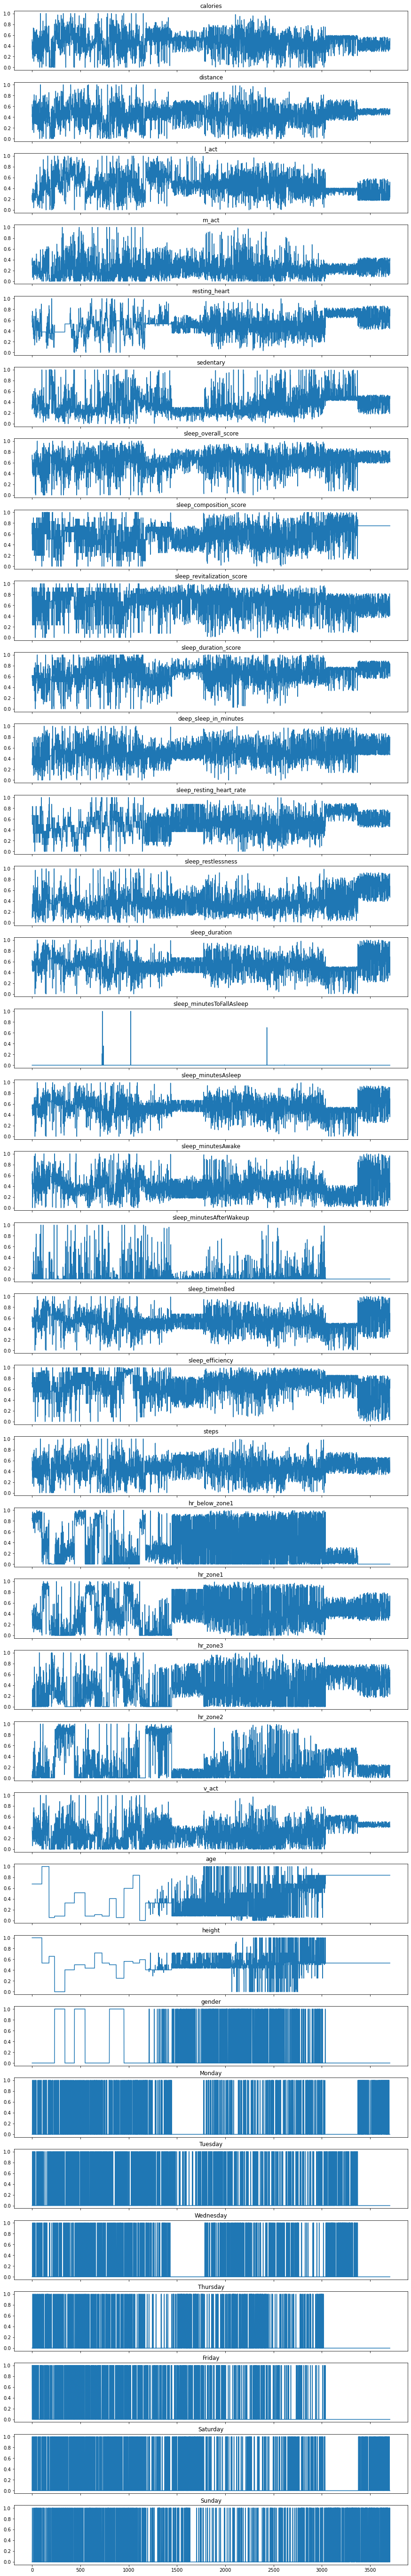

In [7]:
#plotting data

%matplotlib inline

import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(agg_Xtrain.columns), sharex=True, figsize=(15,100))

for i in range(len(agg_Xtrain.columns)):

    axs[i].set_title(agg_Xtrain.columns[i])
    axs[i].plot(agg_Xtrain.iloc[:,i].reset_index(drop=True))
